# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 32

**Author 1 (350508):** Ziyi ZHAO  
**Author 2 (321657):** Yujie HE   
**Author 3 (337088):** Xufeng GAO    

**Release date:** 07.04.2022
**Due date:** 25.04.2022


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [3]:
import cv2 # merge cv2 and cv
import cv2 as cv
import numpy as np
import time
import tarfile
import os
import copy
import pandas as pd
import seaborn as sns
import skimage
from skimage import filters, measure, morphology, exposure, color
from skimage.transform import rescale
from skimage.exposure import histogram, cumulative_distribution, equalize_hist
from scipy import ndimage as ndi
from PIL import Image
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import tarfile
import os

data_base_path = os.path.join('/content/', 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [93]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


First we check the feature space distribution of each class

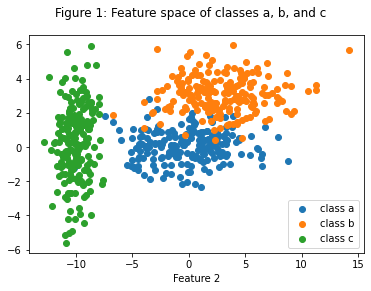

In [6]:
plt.scatter(a[:,0], a[:,1], label='class a')
plt.scatter(b[:,0], b[:,1], label='class b')
plt.scatter(c[:,0], c[:,1], label='class c')
plt.xlabel('Feature 1')
plt.xlabel('Feature 2')
plt.suptitle('Figure 1: Feature space of classes a, b, and c')
plt.legend(loc='lower right')
plt.show()

### 1.1 Bayes method (5 pts)
Using the Bayes method, give the expression of the **separation curves** between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data. Note that you do not need to solve the analytical expression. You can simply evaluate the function for each point on the plane to end up with a segmentation map.
For simplicity reasons, round the estimated parameters to the closest integer value.

### 1.1.1 Background
Bayes method provides a principled way for calculating the conditional probability of a class label given a data sample. By definition, Bayes method states the following relationship, given a class variable $w_i$ and a dependent feature vactor $x$:
$$
P(w_i|x) = \frac{P(x|w_i)P(w_i)}{P(x)}
\tag{1}
$$
If we are trying to decide between two class labels, such as $w_a$ and $w_b$ corresponding to class a and b in our case, then one way to make this decision is to compute the ratio of the posterior probabilities for each data sample:
$$
\frac{P(w_a|x)}{P(w_b|x)}=\frac{P(x|w_a)P(w_a)}{P(x|w_b)P(w_b)}=\frac{P(x|w_a)}{P(x|w_b)}
\tag{2}
$$

Because the training sets of each class have the same amount of data in our case, the prior probability of each calss $P(w_i)$ is always 1/3. All we need now is some model by which we can compute $P(x|w_i)$ for each label. Such a model is called a generative model because it specifies the hypothetical random process that generates the data, which in practice requires an enormous number of samples (very large-sized dataset) and is computationally expensive. 

In order to make it simpler, the following naive assumptions are made:
- we assume the effect of a particular feature in a class is independent of other features.
- we assume the data from each class is drawn from a Gaussian distribution

In order to support our assumptions, the data distribution plots for each class are provided. As shown in above figure, all 3 classes give a Gaussian-like distribution, which validates our assumptions.




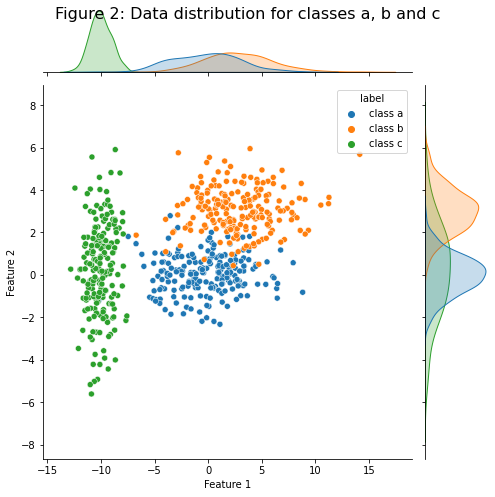

In [123]:
df_a = pd.DataFrame(a, columns=['Feature 1', 'Feature 2'])
df_b = pd.DataFrame(b, columns=['Feature 1', 'Feature 2'])
df_c = pd.DataFrame(c, columns=['Feature 1', 'Feature 2'])
df_a['label'] = 'class a'
df_b['label'] = 'class b'
df_c['label'] = 'class c'
all_data = pd.concat([df_a, df_b, df_c], ignore_index=True)
sns.jointplot(data=all_data, x='Feature 1', y='Feature 2', hue='label', height=7)
plt.suptitle('Figure 2: Data distribution for classes a, b and c', size=16)
plt.show()

The **separation curve** is defined as the set of potints where the probability to classify a sample in two different classes $i,j$ is the same, which gives: 

$$
P(w_i|x) = P(w_j|x)⟺P(w_i|x) - P(w_j|x) = 0 
\tag{3}
$$

From Equation 1 we then have:

$$
P(x|w_i)P(w_i) = P(x|w_j)P(w_j)
\tag{4}
$$

As our classes follow the Gaussian distribution, the probability items in Equations 3 and 4 can be described by a discriminat function as follows:

\begin{equation} 
\begin{split}
g_i(x) & = ln(P(w_i|x)) = ln(P(x|w_i)P(w_i)) = ln(P(x|w_i)) + ln(P(w_i)) \\
& = -\frac{1}{2}(x-μ_i)^T \Sigma_{i}^{-1} (x-μ_i) + lnP(w_i) + c_i 
\end{split}
\tag{5}
\end{equation}

where,
- $μ_i$ is the mean of class $w_i$.
- $\Sigma_i$ is the covariance matrix between features. For 2-feature class, with our first assumption, $\Sigma_i = \begin{bmatrix} σ_1^2 & 0 \\ 0 & σ_2^2\end{bmatrix}$, $σ_1^2$ and $σ_2^2$ are variance for features. 
- $c_i$ is a constant, which is $\ln{\frac{1}{\sqrt{{(2\pi)}^k|\Sigma_{i}|}}}$, $k=rank(\Sigma_{i})$.

Thus, for a 2D class, teh Equation 5 can be further expanded as:
$$
g_i(x) = -\frac{1}2(\frac{x_1^2}{\sigma_1^2}+\frac{x_2^2}{\sigma_2^2})+(\frac{x_1\mu_1}{\sigma_1^2}+\frac{x_2\mu_2}{\sigma_2^2})-\frac{1}2(\frac{\mu_1^2}{\sigma_1^2}+\frac{\mu_2^2}{\sigma_2^2}) + \ln{P(w_i)} + \ln{\frac{1}{2πσ_1σ_2}}
\tag{6}
$$

Thus, the **separation curve** can be expressed as:
$$
g_{i,j}(x) = g_i(x) - g_j(x) = 0
\tag{7}
$$

It is obvious that:
- the separation curve is hyper quadrics if two classes have different covariance matrices. 
- If all classes have the same covariance matrix, the quadratic terms will vanish and a simple linear classifier can be used to separate these classes.
- The prior probability $\ln{P(w_i)}$ will be canceled out.


From Fig.2, we can see that the shapes of the two distributions for classes a and b are quite similar, which means these two classes have similar covariance matrices. Therefore, we can infer that the separation curve between class a and class b is close to a line. For class c, a quadratic separation curve may be required because its distribution shape is quite different from the other classes.

In [8]:
cov_a = df_a.cov()
cov_a

,Feature 1,Feature 2
Feature 1,10.027697,0.131623
Feature 2,0.131623,0.839327


In [17]:
cov_a.to_numpy() + 10

array([[20.02769733, 10.13162336],
       [10.13162336, 10.83932673]])

In [10]:
cov_b = df_b.cov()
cov_b

,Feature 1,Feature 2
Feature 1,10.170348,0.180238
Feature 2,0.180238,1.084004


In [11]:
cov_c = df_c.cov()
cov_c

,Feature 1,Feature 2
Feature 1,0.970130,0.234581
Feature 2,0.234581,4.697563


The results show that the elements in the right diagonal are much smaller than others, which means that the two features are independent of each other. Moreover, the covariance matric of class a is quite similar to the one obtained from class b, which confirms our obsrvations on the shapes of distribution.

### 1.1.2 Plot separation curve

We plot the separation curves based on the Equations 6 and 7.

In [128]:
def discriminant(x_1, x_2, data_set):
  cov = data_set.cov().to_numpy()
  mean = data_set.mean().to_numpy()
  var_1 = cov[0,0]
  var_2 = cov[1,1]
  mean_1 = mean[0]
  mean_2 = mean[1]
  constant = -0.5 * (mean_1**2/var_1 + mean_2**2/var_2) + np.log(1/(2*np.pi*np.sqrt(var_0*var_1)))
  g = -0.5 * (x_1**2/var_1 + x_2**2/var_2) + x_1*mean_1/var_1 + x_2*mean_2/var_2 + constant
  return g

In [129]:
# find the max_min limits in feature space
max_F1 = all_data['Feature 1'].max()
min_F1 = all_data['Feature 1'].min()
max_F2 = all_data['Feature 2'].max()
min_F2 = all_data['Feature 2'].min()
print(max_F1, min_F1, max_F2, min_F2)
# produce a meshgrid that covers the entire feature space
range_F1 = np.arange(min_F1, max_F1, 0.1)
range_F2 = np.arange(min_F2, max_F2, 0.1)
grid_F1, grid_F2 = np.meshgrid(range_F1, range_F2)

# calculate discrinant for each class
g_a = discriminant(grid_F1, grid_F2, df_a)
g_b = discriminant(grid_F1, grid_F2, df_b)
g_c = discriminant(grid_F1, grid_F2, df_c)

# calculate separation curve
g_ab = g_a - g_b
g_ac = g_a - g_c
g_bc = g_b - g_c

14.152334479544306 -12.826383526964545 5.949092541315588 -5.613352409864229


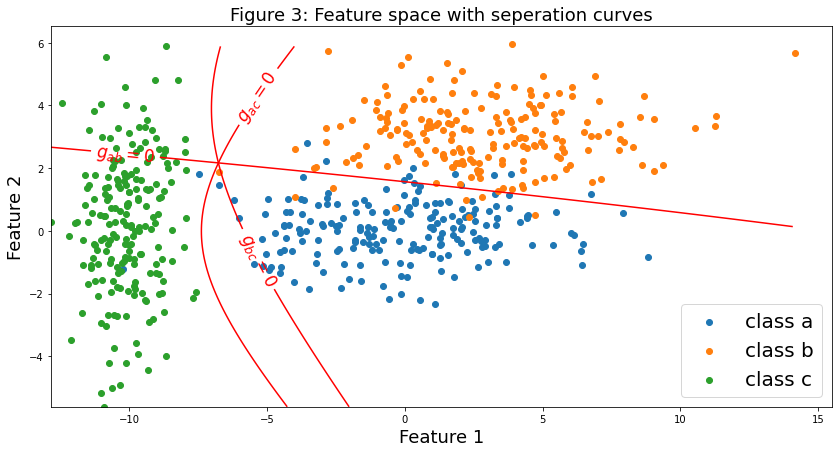

In [140]:
# draw data sets
fig, ax = plt.subplots(figsize=(14,7))
ax.scatter(a[:,0], a[:,1], label='class a')
ax.scatter(b[:,0], b[:,1], label='class b')
ax.scatter(c[:,0], c[:,1], label='class c')
ax.set_xlabel('Feature 1', fontsize=18)
ax.set_ylabel('Feature 2', fontsize=18)
ax.set_title('Figure 3: Feature space with separation curves', fontsize=18)
ax.legend(loc='lower right', fontsize=20)

# draw separation curves
sepCurve_ab = ax.contour(grid_F1, grid_F2, g_ab, 0, colors='red')
sepCurve_ac = ax.contour(grid_F1, grid_F2, g_ac, 0, colors='red')
sepCurve_bc = ax.contour(grid_F1, grid_F2, g_bc, 0, colors='red')

# show labels
ax.clabel(sepCurve_ab, inline=True, fmt='$g_{ab}=0$', fontsize=17)
ax.clabel(sepCurve_ac, inline=True, fmt='$g_{ac}=0$', fontsize=17)
ax.clabel(sepCurve_bc, inline=True, fmt='$g_{bc}=0$', fontsize=17)
plt.show()

As shown in Figure 3, the three data classes are well classified using our separate curves, although some samples are still misidentified.

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

In [ ]:
# Add your implementation and discussion

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [ ]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [ ]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

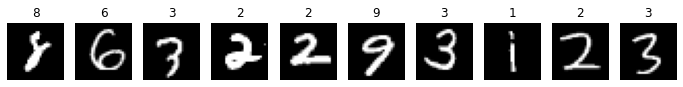

In [ ]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

In [ ]:
train_images.shape

(60000, 28, 28)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [ ]:
# Add your implementation and discussion

The Multi-layer perceptrons(MLP) is one typical model of non-linear classifiers as well as a supervised learning algorithm. Even as one of the simplest and original neural networks, MLP has shown good results in the field of classification problems.

The advantages of Multi-layer Perceptron are:

1) Capability to learn non-linear models.

2) Capability to learn models in real-time (on-line learning) using partial_fit.

The disadvantages of Multi-layer Perceptron (MLP) include:

1) MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.

2) MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.

3) MLP is sensitive to feature scaling.

#### 2.2.1  Using [scikit-learn] to construct the MLP classifier.


[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [ ]:
# (28*28) --> (784,)
train_images_reshape = []
test_images_reshape = []
# The use of zip leads to reduced performance of the program
# for im_train,im_test in zip(train_images, test_images):
#     train_images_reshape.append(im_train.flatten())
#     test_images_reshape.append(im_test.flatten())
for im_train in train_images:
    train_images_reshape.append(im_train.flatten())
for im_test in test_images:
    test_images_reshape.append(im_test.flatten())

In [ ]:
# Based on experience of running the code, the training process generally takes a long time
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, 
                    hidden_layer_sizes=(100), random_state=1)

In [ ]:
clf.fit(train_images_reshape, train_labels)

In [ ]:
predicted_labels=clf.predict(test_images_reshape)

#### Notes:
1. Sigmoid and softmax
2. training algorithm  
3. Cross-Entropy loss function： Currently, MLPClassifier supports only the Cross-Entropy loss function, which allows probability estimates by running the predict_proba method.

    MLP trains using Backpropagation. More precisely, it trains using some form of gradient descent and the gradients are calculated using Backpropagation. For classification, it minimizes the Cross-Entropy loss function, giving a vector of probability estimates P(y|x) per sample x.(reference: https://scikit-learn.org/stable/modules/neural_networks_supervised.html)
4. solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
    The solver for weight optimization.
    
    ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.

    ‘sgd’ refers to stochastic gradient descent.

    ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba

    Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.

#### 2.2.2 Using Pytorch to consracu the MLP classfiier.